In [1]:
%load_ext autoreload
%autoreload 2

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import stat
import asyncio
from scipy import stats
from scipy.stats import test
from finance.moex import shares, index

sns.set_style("darkgrid")

In [86]:
tickers = await index.fetch_stock_tickers("IMOEX")
print(len(tickers))
display(tickers.head())
tickers = tickers.set_index("ticker")



dict_keys(['tickers'])
123


,ticker,from,till,tradingsession
0,AFKS,2012-09-18,2025-10-22,3
1,AFLT,2001-04-28,2025-10-22,3
2,AGRO,2015-12-16,2024-12-02,3
3,AKRN,2012-12-18,2017-12-21,3
4,ALRS,2012-12-18,2025-10-22,3


In [87]:
ofz = index.fetch_index(verbose=True)
sber = shares.share_adjusted("SBER", verbose=True)

ofz, sber = await asyncio.gather(ofz, sber)

/home/raccoon/.local/share/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python3.12/json/decoder.py:354: RuntimeWarning: coroutine 'fetch_index' was never awaited
  obj, end = self.scan_once(s, idx)


In [90]:
print("OFZ:")
ofz_idx = ofz.index.copy()
ofz_years = ofz_idx.to_series().dt.strftime("%Y").to_list()
start_year = int(str(ofz_years[0]))
end_year = int(str(ofz_years[-1]))

days = []
for year in range(start_year, end_year + 1):
    date_start = pd.to_datetime(str(year))
    date_end = pd.to_datetime(str(year + 1))

    idxs = (date_start <= ofz_idx) * (ofz_idx < date_end)
    if year != start_year and year != end_year:
        days.append(idxs.sum())
    print(f"\tYear: {year}, days: {idxs.sum()}")
print(f"Mean: {np.mean(days)}")
print()

print("SBER:")
ofz_idx = sber.index.copy()
ofz_years = ofz_idx.to_series().dt.strftime("%Y").to_list()
start_year = int(str(ofz_years[0]))
end_year = int(str(ofz_years[-1]))

days.clear()
for year in range(start_year, end_year + 1):
    date_start = pd.to_datetime(str(year))
    date_end = pd.to_datetime(str(year + 1))

    idxs = (date_start <= ofz_idx) * (ofz_idx < date_end)
    if year != start_year and year != end_year:
        days.append(idxs.sum())
    print(f"Year: {year}, days: {idxs.sum()}")
print(f"Mean: {np.mean(days)}")


OFZ:
	Year: 2012, days: 212
	Year: 2013, days: 250
	Year: 2014, days: 250
	Year: 2015, days: 250
	Year: 2016, days: 252
	Year: 2017, days: 252
	Year: 2018, days: 254
	Year: 2019, days: 252
	Year: 2020, days: 250
	Year: 2021, days: 255
	Year: 2022, days: 237
	Year: 2023, days: 254
	Year: 2024, days: 256
	Year: 2025, days: 205
Mean: 251.0

SBER:
Year: 2007, days: 115
Year: 2008, days: 247
Year: 2009, days: 249
Year: 2010, days: 248
Year: 2011, days: 248
Year: 2012, days: 255
Year: 2013, days: 250
Year: 2014, days: 250
Year: 2015, days: 250
Year: 2016, days: 252
Year: 2017, days: 252
Year: 2018, days: 254
Year: 2019, days: 252
Year: 2020, days: 250
Year: 2021, days: 255
Year: 2022, days: 234
Year: 2023, days: 254
Year: 2024, days: 256
Year: 2025, days: 258
Mean: 250.35294117647058


In [ ]:
tickers_names = ["SBER", "GAZP", "PIKK", "YDEX"]
tickers = await asyncio.gather(*[shares.share_adjusted(name) for name in tickers_names])

datas = [ofz] + tickers
names = ["OFZ"] + tickers_names

In [130]:
def get_share_stats(shares, share_names, date=1974, end_date=2030, pvalue = 0.05):
    rows = []
    
    for share, share_name in zip(shares, share_names):
        where = (share.index >= pd.to_datetime(str(date))) * (share.index < pd.to_datetime(str(end_date)))
        share = share.loc[where]
        if len(share) == 0:
            continue
        
        log_ret = share["logret"].to_numpy()
        log_ret = log_ret[~np.isnan(log_ret)]

        row = {}
        row["Name"] = share_name
        row["Mean (%)"] = np.mean(log_ret) * 100
        row["Std (%)"] = np.std(log_ret) * 100
        row["Variance"] = np.std(log_ret) ** 2
        row["Skewness"] = stats.skew(log_ret)
        row["Excess kurtosis"] = stats.kurtosis(log_ret) - 3
        row["Min (%)"] = np.min(log_ret) * 100
        row["Max (%)"] = np.max(log_ret) * 100

        row["E=0 pvalue"] = stats.ttest_1samp(log_ret, 0).pvalue

        row["Annual Mean (%)"] = np.mean(log_ret) * 252 * 100
        
        rows.append(row)
    display(pd.DataFrame(rows))


In [132]:
print("Все время")
get_share_stats(datas, names)
print("2016-2020")
get_share_stats(datas, names, 2016, 2020)
print("2020-н.в.")
get_share_stats(datas, names, 2020)
print("2024-н.в.")
get_share_stats(datas, names, 2024)

Все время


,Name,Mean (%),Std (%),Variance,Skewness,Excess kurtosis,Min (%),Max (%),E=0 pvalue,Annual Mean (%)
0,OFZ,0.026841,0.520252,0.000027,-7.828310,230.451183,-14.845142,4.768127,0.002544,6.763899
1,SBER,0.032799,2.669714,0.000713,-1.133933,30.520235,-45.591829,30.118497,0.403368,8.265419
2,GAZP,0.030953,2.291752,0.000525,-0.311769,57.051492,-36.319951,31.101586,0.466383,7.800269
3,PIKK,0.041395,2.149508,0.000462,-0.617680,11.303940,-25.951120,16.614334,0.247840,10.431588
4,YDEX,-0.006426,1.982664,0.000393,0.548325,-1.255043,-5.006350,9.819203,0.950525,-1.619338


2016-2020


,Name,Mean (%),Std (%),Variance,Skewness,Excess kurtosis,Min (%),Max (%),E=0 pvalue,Annual Mean (%)
0,OFZ,0.045729,0.225742,0.000005,-0.459880,2.146010,-1.395415,0.970506,1.909371e-10,11.523642
1,SBER,0.097921,1.783613,0.000318,-1.178032,9.848210,-18.684963,7.732352,8.148051e-02,24.676181
2,GAZP,0.087630,1.532112,0.000235,1.499633,9.216061,-7.782188,15.153552,6.954291e-02,22.082830
3,PIKK,0.072062,1.304865,0.000170,-0.471675,7.951474,-11.843260,7.899033,7.969554e-02,18.159582


2020-н.в.


,Name,Mean (%),Std (%),Variance,Skewness,Excess kurtosis,Min (%),Max (%),E=0 pvalue,Annual Mean (%)
0,OFZ,0.014677,0.637870,0.000041,-8.157799,207.490140,-14.845142,4.707307,0.380108,3.698522
1,SBER,0.040108,2.452538,0.000601,-4.505182,82.662241,-45.591829,12.364750,0.525754,10.107336
2,GAZP,-0.001714,2.806322,0.000788,-0.475203,47.104834,-36.319951,31.101586,0.981091,-0.431990
3,PIKK,0.002696,2.670057,0.000713,-0.816588,9.441568,-25.951120,16.614334,0.968744,0.679501
4,YDEX,-0.006426,1.982664,0.000393,0.548325,-1.255043,-5.006350,9.819203,0.950525,-1.619338


2024-н.в.


,Name,Mean (%),Std (%),Variance,Skewness,Excess kurtosis,Min (%),Max (%),E=0 pvalue,Annual Mean (%)
0,OFZ,0.030040,0.492016,0.000024,2.031060,9.297496,-1.422847,3.780365,0.191027,7.570040
1,SBER,0.055712,1.616410,0.000261,1.939717,12.130467,-6.797163,12.364750,0.435368,14.039438
2,GAZP,-0.060394,2.123480,0.000451,0.324167,-0.764539,-7.621944,8.206236,0.519753,-15.219173
3,PIKK,-0.106504,2.998106,0.000899,0.373547,0.563778,-10.276936,16.614334,0.421426,-26.838998
4,YDEX,-0.006426,1.982664,0.000393,0.548325,-1.255043,-5.006350,9.819203,0.950525,-1.619338


Index(['CLOSE', 'logret'], dtype='object')


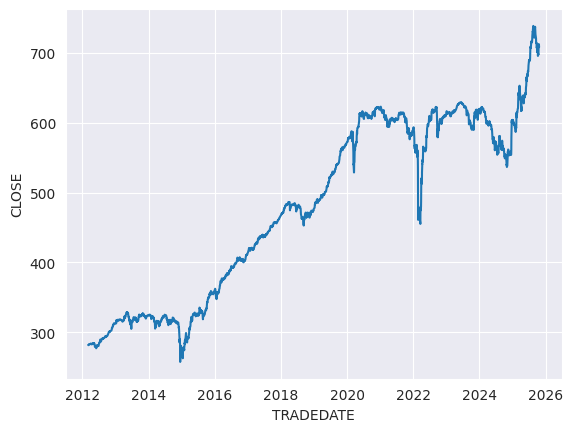

In [113]:
print(ofz.columns)
sns.lineplot(data=ofz, x=ofz.index, y="CLOSE")
plt.show()